# Compute $C_{\ell}$ from DESI iron data 

- [ ] Compute $\delta$ with PCA_qsonic
- [ ] $C^{-1}$ weighting of each forest
- [ ] compute mean delta for each line of sight
- [ ] save {RA, DEC, Z, $\delta$}

In [ ]:
import numpy  as np
import healpy as hp
import sys
#
import matplotlib.pyplot as plt

In [ ]:
%env JAX_ENABLE_X64=True
#
sys.path.insert(0, '/global/homes/r/rmvd2/lya_Cl/directsht-lya/')
from sht.sht                import DirectSHT
from sht.mocks              import LogNormalMocks
from sht.mask_deconvolution import MaskDeconvolution

In [ ]:
%env JAX_ENABLE_X64=True
# check if JAX running on CPU / GPU / TPU 
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

## load DESI data

In [4]:
def read_data(file_path):
    # Load data from the text file
    data = np.loadtxt(file_path)

    # Extract column names from the header
    with open(file_path, 'r') as file:
        header = file.readline().strip()
        column_names = header.split()

    # Create a dictionary to store data with column names
    data_dict = {}
    column_names = column_names[1:]
    for i, column_name in enumerate(column_names):
        data_dict[column_name] = data[:, i]

    return column_names, data_dict

In [5]:
version = 'v_0.8'
# Example usage:
file_path = f'/pscratch/sd/r/rmvd2/DESI/qsonic_contfit/iron/{version}/mean_delta_maps_cmbxlya/ra_dec_iron.txt'
column_names, data = read_data(file_path)
print(column_names)


['RA', 'Dec', 'Mean_Z', 'Mean_Z_Weighted', 'TID', 'Mean_Delta_W', 'Mean_Delta', 'Sum_Weight', 'num_pix']


In [6]:
ra = data['RA']
dec = data['Dec']
mean_z = data['Mean_Z']
mean_z_weight = data['Mean_Z_Weighted']
tid = data['TID']
Mean_Delta_W = data['Mean_Delta_W']
Mean_Delta = data['Mean_Delta']
Sum_Weight = data['Sum_Weight']
num_pix = data['num_pix']
mean_weight = Sum_Weight/num_pix
Mean_Delta_W_all = np.mean(Mean_Delta_W)

# subtract mean from the map
Mean_Delta_W -= Mean_Delta_W_all

# remove outliers from the map
delta_cut = 3
delta_mask = (Mean_Delta_W>-delta_cut) & (Mean_Delta_W<delta_cut)
print('removed', len(Mean_Delta_W)-np.sum(delta_mask), 'outliers')

removed 1789 outliers


In [7]:
# define for SHT 
wrand = mean_weight
wdata = Mean_Delta_W

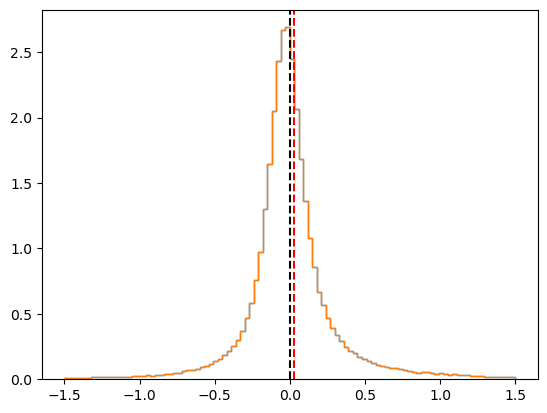

In [8]:
plt.hist(Mean_Delta_W, range=(-1.5, 1.5), bins=100, density=True, histtype='step');
plt.hist(Mean_Delta_W[delta_mask], range=(-1.5, 1.5), bins=100,density=True, histtype='step');
plt.axvline(0, color='k', linestyle='--')
plt.axvline(Mean_Delta_W_all, color='r', linestyle='--')

### convert to galactic coordinates

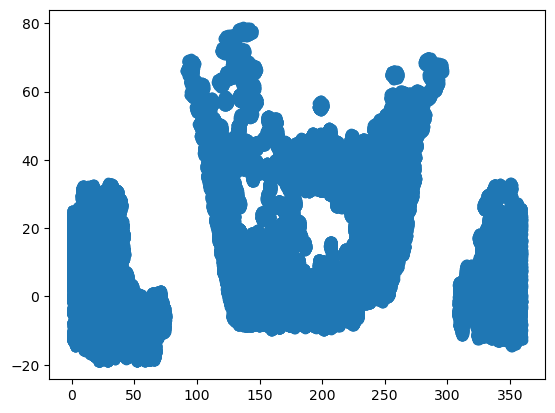

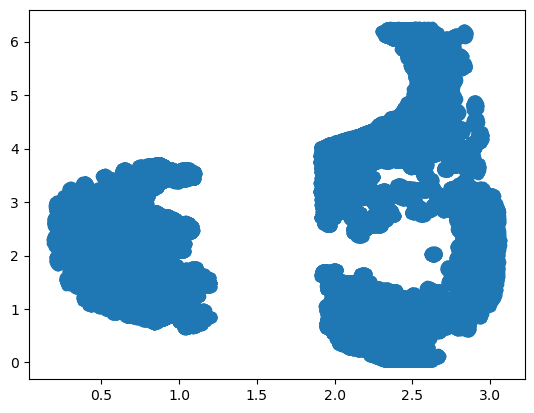

In [9]:
from astropy.coordinates import SkyCoord
import astropy.units as u

plt.scatter(data['RA'], data['Dec']);plt.show()

# Create SkyCoord object with RA and Dec data in degrees
c_icrs = SkyCoord(data['RA']* u.deg, data['Dec']* u.deg, frame='icrs')

# Transform coordinates to Galactic frame
c_galactic = c_icrs.transform_to('galactic')

# Extract theta and phi angles in radians
tdata_rad = c_galactic.spherical.lat  # Galactic  in radians
pdata_rad = c_galactic.spherical.lon    # Galactic  in radians

tdata = tdata_rad.to(u.rad).value+np.pi/2.
pdata = pdata_rad.to(u.rad).value

plt.scatter(tdata, pdata);plt.show()


In [10]:

def make_healpix_density_map(ra, dec, nside, weights=None, save_map=False, save_name=None, do_plot=False, title=None):
    """
    takes in a catalogue and makes healpix map
    """
    nside_lr = 16
    pixels = hp.ang2pix(nside, theta=ra, phi=dec, lonlat=True)
    pixels_lr = hp.ang2pix(nside_lr, theta=ra, phi=dec, lonlat=True)
    if weights is not None:
        fmap = np.bincount(pixels, weights=weights, minlength=hp.nside2npix(nside))
        fmap_lr = np.bincount(pixels_lr, weights=weights, minlength=hp.nside2npix(nside_lr))
    else:
        fmap = np.bincount(pixels, minlength=hp.nside2npix(nside))
        fmap_lr = np.bincount(pixels_lr, minlength=hp.nside2npix(nside_lr))

    if save_name is not None and save_map:
        hp.write_map(save_name, fmap, overwrite=True)
    if do_plot:
        # Mask pixels that are zero in grey
        mask = fmap_lr == 0
        fmap_lr[mask] = np.nan
        hp.mollview(fmap_lr, title='%s (Nside=16)'%title);plt.show()
    return fmap

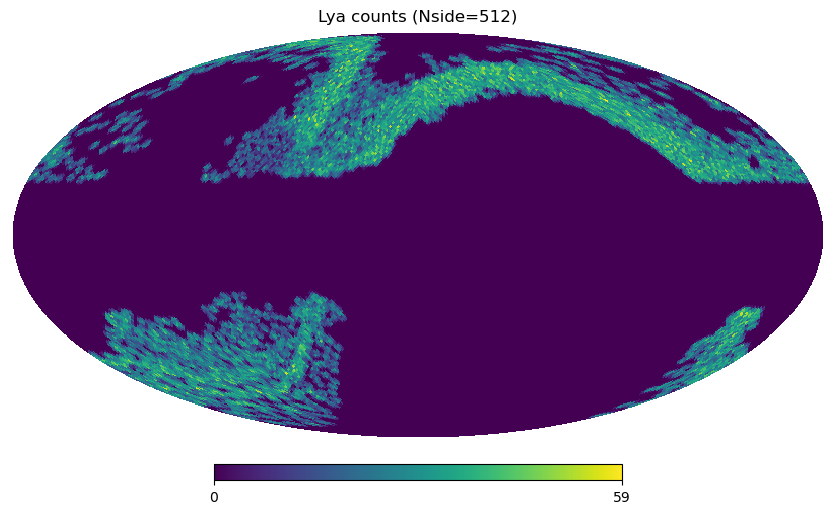

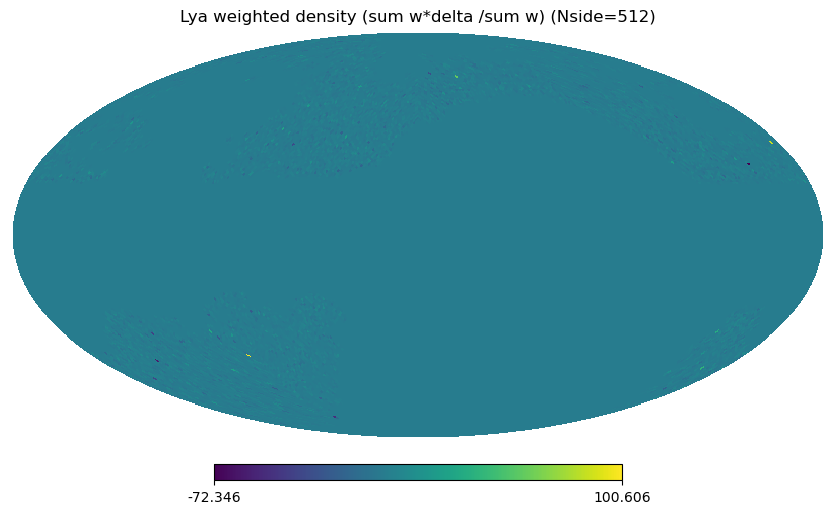

In [11]:
mm = make_healpix_density_map(c_galactic.l.value, c_galactic.b.value, nside=64, weights=None, save_map=False, save_name=None, do_plot=False, title=None)
hp.mollview(mm, title='Lya counts (Nside=512)');plt.show()
mm = make_healpix_density_map(c_galactic.l.value, c_galactic.b.value, nside=64, weights=Mean_Delta_W, save_map=False, save_name=None, do_plot=False, title=None)
hp.mollview(mm, title='Lya weighted density (sum w*delta /sum w) (Nside=512)');plt.show()
#hp.write_map('/pscratch/sd/r/rmvd2/CMBxLya/data/lya_mean_delta_weights.fits', mm)

## load Planck maps 

In [12]:
def unmask(x, mask):
    y=np.zeros(len(mask))
    y[mask==1] = x
    return y

In [13]:
# NPIPE
fcmb = '/global/cfs/cdirs/cmb/data/planck2020/PR4_lensing/PR4_klm_dat_p.fits'
fmask = '/global/cfs/cdirs/cmb/data/planck2020/PR4_lensing/mask.fits.gz'

# Planck PR3
fcmb  = '/pscratch/sd/r/rmvd2/CMBxLya/data/COM_Lensing_4096_R3.00/MV/dat_klm.fits'
fmask = '/pscratch/sd/r/rmvd2/CMBxLya/data/COM_Lensing_4096_R3.00/mask.fits.gz'

NSIDE=2048

cmb_alm = hp.read_alm(fcmb)
cmb_map = hp.alm2map(cmb_alm, nside=NSIDE)

cmb_mask = hp.read_map(fmask)

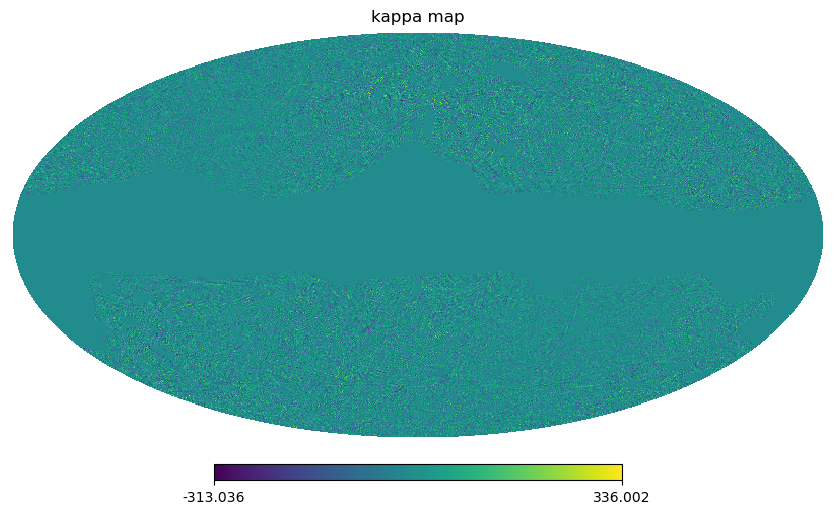

In [14]:
hp.mollview(unmask(cmb_map[cmb_mask==1], cmb_mask), title='kappa map')

In [15]:
cl_cmb = hp.anafast(cmb_map*cmb_mask, lmax=1000)

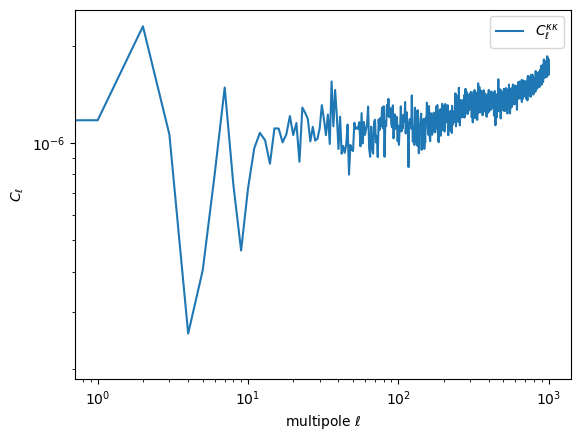

In [16]:
plt.figure()
plt.loglog(cl_cmb, label=r'$C_{\ell}^{\kappa \kappa}$')
plt.xlabel(r'multipole $\ell$')
plt.ylabel(r'$C_{\ell}$')
plt.legend();plt.show()

## Harmonic analysis

First do a "direct harmonic analysis" of the data and random points by applying the SHT, differencing, and then computing the psuedo-spectrum.  We will start by finding the window function from the randoms ...

In [33]:
# Set up an sht instance.
Nl   = 700
Nx   = 2*Nl
xmax = 3./4.
#
sht= DirectSHT(Nl,Nx,xmax)
#
# We'll want to go to higher lmax in W_l to do mode-decoupling
buffer_ells = 64
sht_randoms = DirectSHT(Nl+buffer_ells,Nx,xmax)
#
print("For general, Direct SHT has Nl=",sht.Nell,", Nx=",Nx," and xmax=",xmax)
print("For randoms, Direct SHT has Nl=",sht_randoms.Nell,", Nx=",Nx," and xmax=",xmax)

For general, Direct SHT has Nl= 700 , Nx= 1400  and xmax= 0.75
For randoms, Direct SHT has Nl= 764 , Nx= 1400  and xmax= 0.75


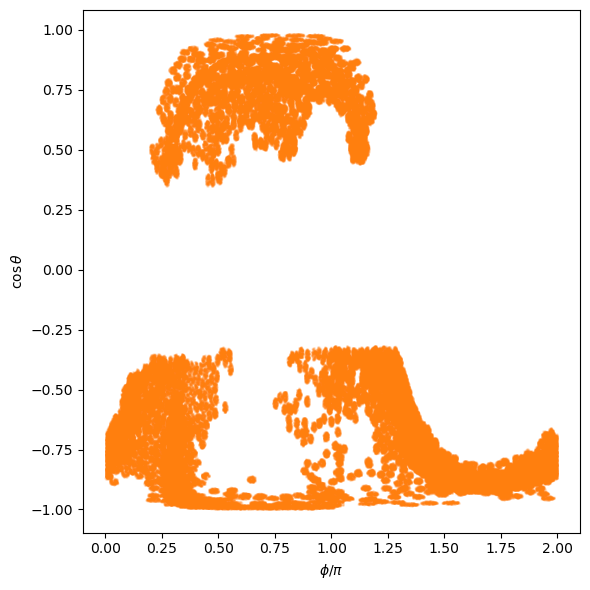

In [34]:
# plt.scatter(tdata, pdata)

fig,ax = plt.subplots(1,1,figsize=(6,6))
#
ax.scatter(pdata/np.pi,np.cos(tdata),s=1,c='C1',alpha=0.1,label='Data',rasterized=False)
ax.set_xlabel(r'$\phi/\pi$')
ax.set_ylabel(r'$\cos\theta$')
plt.tight_layout()

In [35]:
# Get harmonic coefficients for the data and measure raw Cls
hdat = sht(tdata,pdata,wdata)
hdcl = hp.alm2cl(hdat)
#
# Do the same for the randoms.
hran = sht(tdata,pdata,wrand)
hrcl = hp.alm2cl(hran)
#
# and for the difference of data and randoms:
hdif = hp.alm2cl(hdat-hran)
print("hatC in range [{:e},{:e}]".format(np.min(hdif[1:]),np.max(hdif[1:])))
#

Sorting & digitizing took  0.028067827224731445  seconds.
Reshaping took  0.07261919975280762  seconds.
Precomputing vs took  1.2355124950408936  seconds.
Computing alm's took  7.1045310497283936  seconds.
Sorting & digitizing took  0.02170705795288086  seconds.
Reshaping took  0.06014871597290039  seconds.
Precomputing vs took  0.9926562309265137  seconds.
Computing alm's took  6.785044431686401  seconds.
Sorting & digitizing took  0.022293567657470703  seconds.
Reshaping took  0.043642520904541016  seconds.
Precomputing vs took  1.0518088340759277  seconds.
Computing alm's took  4.6469151973724365  seconds.
Sorting & digitizing took  0.028792858123779297  seconds.
Reshaping took  0.04414224624633789  seconds.
Precomputing vs took  1.3900117874145508  seconds.
Computing alm's took  4.877309799194336  seconds.
Sorting & digitizing took  0.0074574947357177734  seconds.
Reshaping took  0.06664514541625977  seconds.
Precomputing vs took  1.062694787979126  seconds.
Computing alm's took  7

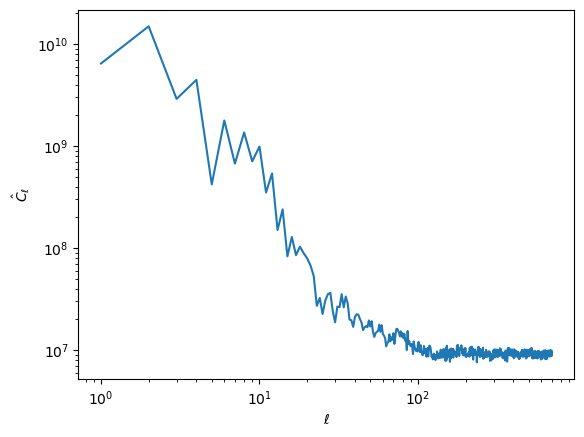

In [36]:
plt.loglog(np.arange(1,hdif.size),hdif[1:])
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\hat{C}_\ell$')
plt.savefig('./plots/window_convolved_Cell.pdf', bbox_inches='tight')

In [37]:
# Calculate the angular power spectrum of the randoms
#
hran_for_wl = sht_randoms(tdata,pdata,wrand)
#  After subtracting shot noise, this gives us the
#  angular power spectrum of the window function 
# sn = 1.0/float(nrand)/(4*np.pi) * float(ndata)**2

# ignore shot noise for now

wl = hp.alm2cl(hran_for_wl)# - sn

Sorting & digitizing took  0.00751042366027832  seconds.
Reshaping took  0.06776762008666992  seconds.
Precomputing vs took  1.2129628658294678  seconds.
Computing alm's took  8.08352541923523  seconds.
Sorting & digitizing took  0.006063938140869141  seconds.
Reshaping took  0.05801105499267578  seconds.
Precomputing vs took  1.05684494972229  seconds.
Computing alm's took  8.011500358581543  seconds.
Sorting & digitizing took  0.005810737609863281  seconds.
Reshaping took  0.043707847595214844  seconds.
Precomputing vs took  1.1017391681671143  seconds.
Computing alm's took  5.223664999008179  seconds.
Sorting & digitizing took  0.009432792663574219  seconds.
Reshaping took  0.04394674301147461  seconds.
Precomputing vs took  1.4602911472320557  seconds.
Computing alm's took  5.589361667633057  seconds.


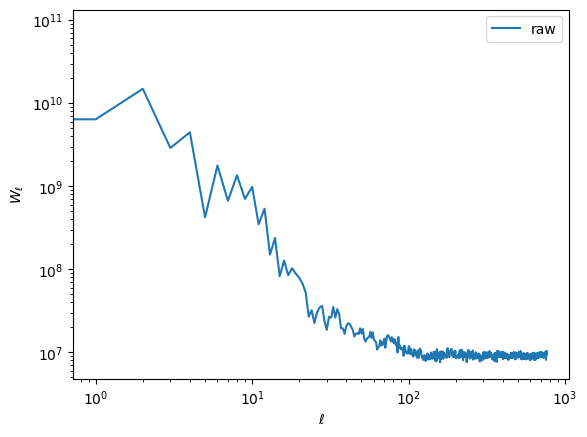

In [38]:
plt.loglog(wl,label='raw')
#
plt.xlabel(r'$\ell$')
plt.ylabel(r'$W_\ell$')
plt.legend()
plt.savefig('./plots/harmonic_window.pdf', bbox_inches='tight')

In [39]:
# Initialize an instance of the MaskDeconvolution. This will let us deconvolve
# the mask-induced mode-coupling of the pseudo-Cls, convolved the theory to
# enable apples-to-apples comparisons, and provide binning functionality
%time MD = MaskDeconvolution(Nl+buffer_ells,wl)
#
NperBin = 2**5
bins    = MD.binning_matrix('linear',0,NperBin)
Mbl     = MD.window_matrix(bins)
# Look at the sums over ell.
print("\nRow sums of Mbl:")
print(Mbl.sum(axis=1))

Precomputing Wigner 3j symbols...
Computing the mode-coupling matrix...
CPU times: user 5min 52s, sys: 2.29 s, total: 5min 54s
Wall time: 5min 54s

Row sums of Mbl:
[1.10671719 0.88321552 0.88855067 0.89695801 0.9112517  0.92627985
 0.94444353 0.96527968 0.98499057 1.00221891 1.01692169 1.03531527
 1.04771625 1.06079157 1.06834699 1.07533398 1.08149413 1.0858205
 1.08631057 1.08204391 1.08257804 1.08370819 1.16813263]


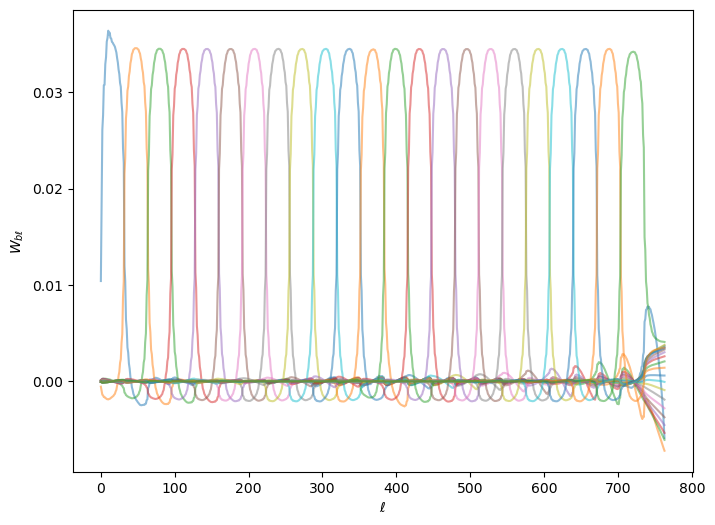

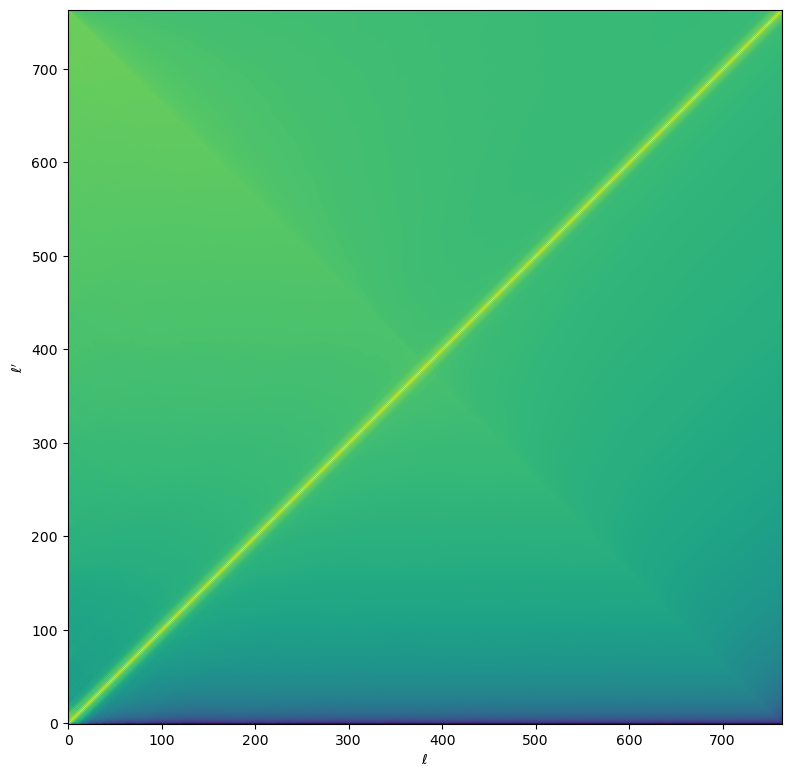

In [40]:
# Plot the matrix:
fig,ax = plt.subplots(1,1,figsize=(8,6))
for i in range(Mbl.shape[0]):
    ax.plot(Mbl[i,:],alpha=0.5,label='Bin '+str(i))
#ax.legend(bbox_to_anchor=(1.1,1.0))
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$W_{b\ell}$')
plt.savefig('./plots/harmonic_wbl.pdf', bbox_inches='tight')
#
# and plot the mode-coupling matrix itself.
fig,ax = plt.subplots(1,1,figsize=(8,8))
mode_coupling = np.log( 1+MD.Mll.clip(0,1e30) )
ax.imshow(mode_coupling.T,origin='lower')
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$\ell^\prime$')
plt.tight_layout()
plt.savefig('./plots/harmonic_mll.pdf', bbox_inches='tight')

In [41]:
# Now work out the binned and decoupled pseudo-spectrum.
# The first Ndiscard bins are removed because they have
# support to very low ell and the last bins because
# they have support past lmax
Ndiscard = 2
binned_ells,hdif_decoupled = MD(hdif,bins)
binned_ells,hdif_decoupled = binned_ells[Ndiscard:-Ndiscard],hdif_decoupled[Ndiscard:-Ndiscard]

In [42]:
print(binned_ells)
print(hdif_decoupled)

[ 79.5 111.5 143.5 175.5 207.5 239.5 271.5 303.5 335.5 367.5 399.5 431.5
 463.5 495.5 527.5 559.5 591.5 623.5 655.5]
[ 1.45537243e-03  1.45677604e-03  1.44074806e-03  1.06404922e-03
  8.24988205e-04  6.58275718e-04  4.91940652e-04  2.36554028e-04
  1.55508156e-05 -1.80882699e-04 -3.62359291e-04 -4.42698340e-04
 -5.94013634e-04 -7.16013424e-04 -7.42010810e-04 -7.44872583e-04
 -7.55337047e-04 -7.41115141e-04 -6.96351442e-04]


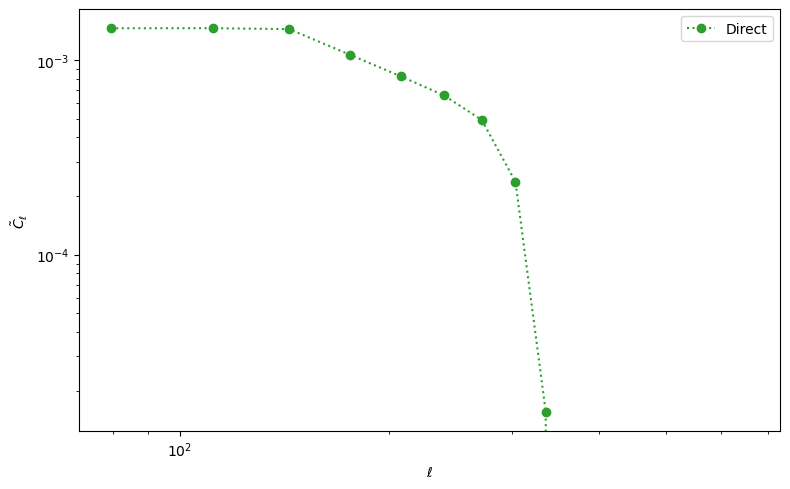

In [43]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
ax.plot(binned_ells,hdif_decoupled,'o:',color='C2',label='Direct')
#
# Compare to the theory convolved with the bandpower window function -- we
# expect some differences due to sample variance, but they shouldn't be huge.
#clt_conv = np.dot(Mbl,cl_theory[:Mbl.shape[1]])
#ax.plot(binned_ells, clt_conv[Ndiscard:-Ndiscard],'o:',color='C1',label='Theory')
#
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$\tilde{C}_\ell$')
#
ax.legend()
plt.tight_layout()
plt.savefig('./plots/harmonic_tildeC.pdf', bbox_inches='tight')

### compute cross-spectrum Lya x CMB lensing 

In [44]:
Nl

700

In [57]:
hp.Alm.getidx(lmax=Nl, l=Nl, m=Nl)*2+1

492101

In [30]:
cl_kF = hp.alm2cl(cmb_alm,hdat-hran)

ValueError: all alms must have same size

In [31]:
hdat.shape

(500500,)

In [32]:
cmb_alm.shape

(8394753,)

In [ ]:
plt.figure()
plt.loglog(cl_kF, label=r'$C_{\ell}^{\kappa F}$')
plt.xlabel(r'multipole $\ell$')
plt.ylabel(r'$C_{\ell}$')
plt.legend();plt.show()